# 나이브 베이즈

In [5]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB

In [9]:
loan_data = pd.read_csv('./datasets/loan_data.csv.gz')
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45342 entries, 0 to 45341
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         45342 non-null  int64  
 1   status             45342 non-null  object 
 2   loan_amnt          45342 non-null  int64  
 3   term               45342 non-null  object 
 4   annual_inc         45342 non-null  int64  
 5   dti                45342 non-null  float64
 6   payment_inc_ratio  45342 non-null  float64
 7   revol_bal          45342 non-null  int64  
 8   revol_util         45342 non-null  float64
 9   purpose            45342 non-null  object 
 10  home_ownership     45342 non-null  object 
 11  delinq_2yrs_zero   45342 non-null  int64  
 12  pub_rec_zero       45342 non-null  int64  
 13  open_acc           45342 non-null  int64  
 14  grade              45342 non-null  float64
 15  outcome            45342 non-null  object 
 16  emp_length         453

In [12]:
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'

In [16]:
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

In [17]:
naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model.fit(X, y)

MultinomialNB(alpha=0.01)

In [19]:
new_load = X.loc[146:146:, :]
new_load

,credit_card,debt_consolidation,home_improvement,major_purchase,medical,other,small_business,MORTGAGE,OWN,RENT,< 1 Year,> 1 Year
146,0,0,0,0,0,0,1,1,0,0,0,1


In [22]:
naive_model.predict(new_load)[0]

'default'

In [24]:
pd.DataFrame(naive_model.predict_proba(new_load),
            columns=loan_data[outcome].cat.categories)

,default,paid off
0,0.653696,0.346304


# 판별분석

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

loan3000 = pd.read_csv('./datasets/loan3000.csv')
loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
print(pd.DataFrame(loan_lda.scalings_, index=X.columns))

                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


In [28]:
pred = pd.DataFrame(loan_lda.predict_proba(X), columns=loan_lda.classes_)
pred.head()

,default,paid off
0,0.553544,0.446456
1,0.558953,0.441047
2,0.272696,0.727304
3,0.506254,0.493746
4,0.609952,0.390048


In [29]:
center = np.mean(loan_lda.means_, axis=0)
center

array([0.50093515, 8.16350619])

In [31]:
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
slope

array([71.99193766])

In [33]:
intercept = center[1] - center[0] * slope
intercept

array([-27.89978562])

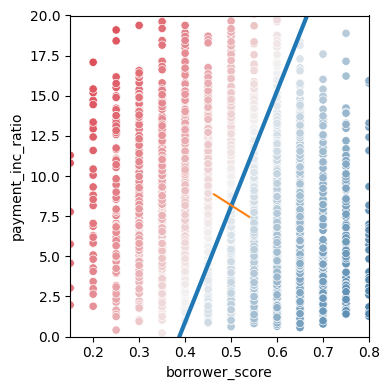

In [36]:
import matplotlib.pyplot as plt 
import seaborn as sns 

x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df, 
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()
plt.show()

# 로지스틱 회귀

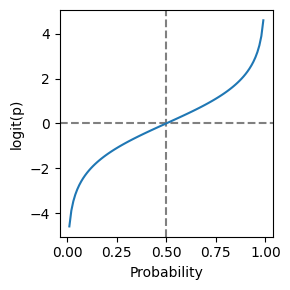

In [39]:
p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1 - p)),
    'odds': p / (1 - p),
})

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0.5, color='grey', linestyle='--')
ax.plot(df['p'], df['logit'])
ax.set_xlabel('Probability')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()

In [40]:
from sklearn.linear_model import LogisticRegression

predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', 
                   drop_first=True, dtype=int)
y = loan_data[outcome] # .cat.categories

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)

intercept  -1.6378909391299383
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079739
borrower_score,4.612184
debt_consolidation,-0.249414
home_improvement,-0.407734
major_purchase,-0.229709
medical,-0.510744
other,-0.620800
small_business,-1.214936
OWN,-0.048211
RENT,-0.157288


In [42]:
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                    columns=logit_reg.classes_)
display(pred.describe())

,default,paid off
count,45342.000000,45342.000000
mean,-0.757872,-0.760434
std,0.378093,0.390456
min,-2.769376,-3.538593
25%,-0.985739,-0.977207
50%,-0.697406,-0.688907
75%,-0.472183,-0.467069
max,-0.029485,-0.064753


In [44]:
pred = pd.DataFrame(logit_reg.predict_proba(X),
                    columns=logit_reg.classes_)
display(pred.describe())

,default,paid off
count,45342.000000,45342.000000
mean,0.500000,0.500000
std,0.167354,0.167354
min,0.062701,0.029054
25%,0.373163,0.376361
50%,0.497875,0.502125
75%,0.623639,0.626837
max,0.970946,0.937299


In [50]:
import statsmodels.api as sm

y_numbers = [1 if yi == 'default' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1), family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Thu, 31 Aug 2023   Deviance:                       57515.
Time:                        08:56:59   Pearson chi2:                 4.54e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1112
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0.002     32.058      0.000       0.075       0.085
borrower_score        -4.6126      0.084    -55.203      0.000      -4.776      -4.449
debt_consolidation     0.2494      0.028      9.030      0.000       0.195       0.303
home_improvement       0.4077      0.047      8.747      0.000       0.316       0.499
major_purchase         0.2296      0.054      4.277      0.000       0.124       0.335
medical                0.5105      0.087      5.882      0.000       0.340       0.681
other                  0.6207      0.039     15.738      0.000       0.543       0.698
small_business         1.2153      0.063     19.192      0.000       1.091       1.339
OWN                    0.0483      0.038      1.271      0.204      -0.026       0.123
RENT                   0.1573      0.021      7.420      0.000       0.116       0.199
 > 1 Year             -0.3567      0.053     -6.779      0.000      -0.460      -0.254
const                  1.6381      0.074     22.224      0.000       1.494       1.783
======================================================================================
"""

In [51]:
import statsmodels.formula.api as smf
formula = ('outcome ~ bs(payment_inc_ratio, df=8) + purpose_ + ' +
           'home_ + emp_len_ + bs(borrower_score, df=3)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45321
Model Family:                                       Binomial   Df Model:                           20
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -28731.
Date:                                       Fri, 01 Sep 2023   Deviance:                       57462.
Time:                                               13:22:50   Pearson chi2:                 4.54e+04
No. Iterations:                                            6   Pseudo R-squ. (CS):             0.1122
Covariance Type:                                   nonrobust                      

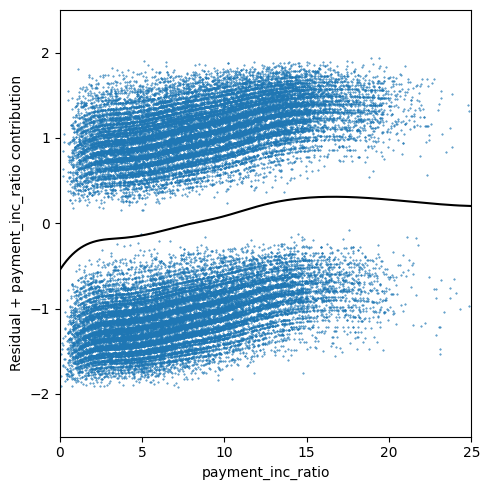

In [52]:
from statsmodels.genmod.generalized_linear_model import GLMResults
def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # set model parametes of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/ 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)


plt.tight_layout()
plt.show()

# 분류 모델 평가하기

In [54]:
# Confusion matrix
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == 'default'
true_y = y == 'default'
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = default', 'Y = paid off'],
                       columns=['Yhat = default', 'Yhat = paid off'])
print(conf_mat)

              Yhat = default  Yhat = paid off
Y = default            14337             8334
Y = paid off            8149            14522


# 불균형 데이터 다루기

In [56]:
full_train_set = pd.read_csv('./datasets/full_train_set.csv.gz')
full_train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119987 entries, 0 to 119986
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   status             119987 non-null  object 
 1   loan_amnt          119987 non-null  int64  
 2   term               119987 non-null  object 
 3   annual_inc         119987 non-null  int64  
 4   dti                119987 non-null  float64
 5   payment_inc_ratio  119987 non-null  float64
 6   revol_bal          119987 non-null  float64
 7   revol_util         119987 non-null  float64
 8   purpose            119987 non-null  object 
 9   home_ownership     119987 non-null  object 
 10  delinq_2yrs_zero   119987 non-null  int64  
 11  pub_rec_zero       119987 non-null  int64  
 12  open_acc           119987 non-null  int64  
 13  grade              119987 non-null  float64
 14  outcome            119987 non-null  object 
 15  emp_length         119987 non-null  int64  
 16  pu

In [57]:
print('percentage of loans in default: ', 
print(      100 * np.mean(full_train_set.outcome == 'default')))

18.894546909248504
percentage of loans in default:  None


In [60]:
full_train_set['outcome'].value_counts(normalize=True)*100

paid off    81.105453
default     18.894547
Name: outcome, dtype: float64

In [69]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'
X = pd.get_dummies(full_train_set[predictors], prefix='', prefix_sep='', 
                   drop_first=True, dtype=int)
y = full_train_set[outcome]

full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y)
print('percentage of loans predicted to default: ',100 * np.mean(full_model.predict(X) == 'default'))

percentage of loans predicted to default:  1.0067757340378543


In [70]:
(np.mean(full_train_set.outcome == 'default') / 
 np.mean(full_model.predict(X) == 'default'))

18.767384105960264

In [71]:
default_wt = 1 / np.mean(full_train_set.outcome == 'default')
wt = [default_wt if outcome == 'default' else 1 for outcome in full_train_set.outcome]

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X, y, wt)
print('percentage of loans predicted to default (weighting):', 100 * np.mean(full_model.predict(X) == 'default'))

percentage of loans predicted to default (weighting): 60.92826722894981
